# Financial Data Science Project

Submitted by : <br>
Avidan Cohen  <br>
Serah Abensour

**Research question:** Defining and testing investment strategies

**Data sources:**

   S&P500 Tickers : We focused on S&P500 stocks (source: Wikipedia)

   Historical Stocks Prices : We download stocks prices from 01/01/2007 to 31/12/2019  (source: Yahoo Finance)
    
**Strategies:** 
1. The dual moving average crossover <br>
2. The moving average crossover <br>
3. Turtle trading <br>
4. The Relative Strength Index (RSI) indicator



# 1. Data Preparation

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import bs4 as bs
import os
from pandas_datareader import data as pdr
import pickle
import requests
import yfinance as yf
from collections import Counter
from statistics import mean
import numpy as np
import math
import warnings

## Importing Financial Data

## SP500

In [3]:
yf.pdr_override

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.replace('.', '-')
        ticker = ticker[:-1]
        tickers.append(ticker)
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    return tickers


#save_sp500_tickers()

def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    start = dt.datetime(2007, 1, 1)
    end = dt.datetime(2019,12,31)
    for ticker in tickers:
        
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            try:
                df = pdr.get_data_yahoo(ticker, start, end)
                df.reset_index(inplace=True)
                df.set_index("Date", inplace=True)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
            except:
                pass
        else:
            print('Already have {}'.format(ticker))


In [4]:
get_data_from_yahoo()

Already have MMM
Already have ABT
Already have ABBV
Already have ABMD
Already have ACN
Already have ATVI
Already have ADBE
Already have AMD
Already have AAP
Already have AES
Already have AFL
Already have A
Already have APD
Already have AKAM
Already have ALK
Already have ALB
Already have ARE
Already have ALXN
Already have ALGN
Already have ALLE
Already have AGN
Already have ADS
Already have LNT
Already have ALL
Already have GOOGL
Already have GOOG
Already have MO
Already have AMZN
Already have AMCR
Already have AEE
Already have AAL
Already have AEP
Already have AXP
Already have AIG
Already have T
Already have AMT
Already have AWK
Already have AMP
Already have ABC
Already have AME
Already have AMGN
Already have APH
Already have ADI
Already have ANSS
Already have ANTM
Already have AON
Already have AOS
Already have APA
Already have AIV
Already have AAPL
Already have AMAT
Already have APTV
Already have ADM
Already have ARNC
Already have ANET
Already have AJG
Already have AIZ
Already have AT

## Compiling in one dataframe

In [10]:
def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()

    for count, ticker in enumerate(tickers):
        try:
            df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
            #df['Ticker']=ticker
            df.set_index('Date', inplace=True)
            
            df.rename(columns={'Adj Close': ticker}, inplace=True)
            df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)
        except:
            pass
     
        if main_df.empty:
            main_df = df
        else:
            #main_df=pd.concat([main_df, df])
            main_df = main_df.join(df, how='outer')


    #main_df = main_df.dropna()
    main_df.to_csv('sp500_joined_closes.csv')
    return main_df


#compile_data()

# 2. Building Trading Strategies and Backtesting

In [2]:
def getprice(date, ticker):
    global prices
    return prices.loc[date][ticker]

In [3]:
def transaction(id, ticker, amount, price, type, info):
    global transactionid
    if type == "buy":
        exp_date = today + dt.timedelta(days=14)
        transactionid += 1
    else:
        exp_date = today
    if type == "sell":
        data = {"id": id, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "exp_date": exp_date, "info": info}
    elif type == "buy":
        data = {"id": transactionid, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "exp_date": exp_date, "info": info}
        activelog.append(data)
    transactionlog.append(data)

In [4]:
def buy(interestlst, allocated_money):
    global money, portfolio
    for item in interestlst:
        price = getprice(today, item)
        if not np.isnan(price):
            quantity = math.floor(allocated_money/price)
            money -= quantity*price
            portfolio[item] += quantity
            transaction(0, item, quantity, price, "buy", "")

In [5]:
def sell():
    global money, portfolio, prices, today
    itemstoremove = []
    for i in range(len(activelog)):
        log = activelog[i]
        if log["exp_date"] <= today and log["type"] == "buy":
            tickprice = getprice(today, log["ticker"])
            if not np.isnan(tickprice):
         
                money += log["amount"]*tickprice
                portfolio[log["ticker"]] -= log["amount"]
                transaction(log["id"], log["ticker"], log["amount"], tickprice, "sell", log["info"])
                itemstoremove.append(i)
            else:
                log["exp_date"] += dt.timedelta(days=1)
    itemstoremove.reverse()
    for elem in itemstoremove:
        activelog.remove(activelog[elem])


In [6]:
def sell2(sellist):
    global money, portfolio, prices, today
    itemstoremove = []
    for i in range(len(activelog)):
        log = activelog[i]
        if log["exp_date"] <= today and log["type"] == "buy" and log["ticker"] in sellist:
            tickprice = getprice(today, log["ticker"])
            if not np.isnan(tickprice):
         
                money += log["amount"]*tickprice
                portfolio[log["ticker"]] -= log["amount"]
                transaction(log["id"], log["ticker"], log["amount"], tickprice, "sell", log["info"])
                itemstoremove.append(i)
            else:
                log["exp_date"] += dt.timedelta(days=1)
    itemstoremove.reverse()
    for elem in itemstoremove:
        activelog.remove(activelog[elem])

In [7]:
def tradingday():
    global prices, today
    return np.datetime64(today) in list(prices.index.values)

In [8]:
def currentvalue():
    global money, portfolio, today, prices
    value = money
    for ticker in tickers:
        tickprice = getprice(today, ticker)
        if not np.isnan(tickprice):
            value += portfolio[ticker]*tickprice
    return  int(value*100)/100

## Method 1: The dual moving average crossover 

The dual moving average crossover occurs when a short-term average crosses a long-term average. This signal is used to identify that momentum is shifting in the direction of the short-term average. A buy signal is generated when the short-term average crosses the long-term average and rises above it, while a sell signal is triggered by a short-term average crossing long-term average and falling below it.

In [11]:
prices=compile_data()

In [12]:
prices.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,55.034485,13.791004,NaN,14.05,27.987869,7.739635,39.919998,19.520000,34.069057,17.299358,...,56.741970,14.030757,37.666531,17.369307,NaN,14.858062,34.880001,71.708916,70.138275,NaN
2007-01-04,54.816502,14.052911,NaN,14.35,28.618711,7.802779,40.820000,19.790001,34.289288,17.307241,...,56.765545,14.042740,37.644257,17.781279,NaN,14.817678,34.680000,73.308632,70.451248,NaN
2007-01-05,54.443768,14.052911,NaN,14.14,28.218664,7.757676,40.619999,19.709999,33.532833,16.810495,...,57.101517,13.761281,37.287640,17.619434,NaN,14.688931,34.330002,73.262131,70.239738,NaN
2007-01-08,54.563339,14.103604,NaN,14.11,28.626410,7.753166,40.450001,19.469999,33.647747,16.573950,...,58.180126,13.761281,37.911713,17.729782,NaN,14.653592,34.400002,72.787804,70.358215,NaN
2007-01-09,54.626602,14.227516,NaN,13.96,28.557161,7.748654,39.630001,19.650000,33.934994,15.895850,...,58.409985,13.755294,37.800270,17.648857,NaN,14.709131,34.340000,72.834297,70.747330,NaN


In [21]:
tickers=prices.columns.to_list()

In [14]:
prices.index = pd.to_datetime(prices.index)

In [16]:
today = dt.date(2008, 1, 1)
simend = dt.date(2019, 12, 31)
tickers = []
transactionid = 0
money = 1000000
portfolio = {}
activelog = []
transactionlog = []

In [17]:
def simulation():
    global today, volumechanges, money
    short_window = 20
    long_window = 80


    start_date_short = today - dt.timedelta(days=short_window)
    start_date_long = today - dt.timedelta(days=long_window)

    short_avg  = pd.DataFrame(columns = ['short'])
    short_avg['short']=prices.loc[start_date_short:today].mean()
    short_avg.index.name='ticker'

    long_avg  = pd.DataFrame(columns = ['long'])
    long_avg['long']=prices.loc[start_date_long:today].mean()
    long_avg.index.name='ticker'

    result = pd.merge(short_avg, long_avg, on='ticker')
    interestlst = result[result['short'] > result['long']].index.tolist()
    sell()
    if len(interestlst) > 0 :
        #moneyToAllocate = 500000/len(interestlst)
        moneyToAllocate = money/(2*len(interestlst))
        buy(interestlst, moneyToAllocate)

In [18]:
def main(tickers):
    global today
    #getindices()
    for ticker in tickers:
        portfolio[ticker] = 0
    while today < simend:
        while not tradingday():
            today += dt.timedelta(days=1)
        simulation()
        currentpvalue = currentvalue()
      
        print(currentpvalue, today)
        today += dt.timedelta(days=7)

In [23]:
main(tickers)

997678.35 2008-01-02
983334.46 2008-01-09
961916.29 2008-01-16
939792.94 2008-01-23
944048.56 2008-01-30
937964.82 2008-02-06
954304.48 2008-02-13
950686.53 2008-02-20
962593.56 2008-02-27
937409.82 2008-03-05
922403.98 2008-03-12
917975.15 2008-03-19
941629.89 2008-03-26
953549.65 2008-04-02
946284.81 2008-04-09
1180227.79 2008-04-16
1182051.13 2008-04-23
1190712.45 2008-04-30
1193243.67 2008-05-07
1212924.68 2008-05-14
1200120.04 2008-05-21
1206708.54 2008-05-28
1207333.43 2008-06-04
1180460.96 2008-06-11
1188933.24 2008-06-18
1178482.59 2008-06-25
1140127.44 2008-07-02
1130715.47 2008-07-09
1130776.91 2008-07-16
1125550.75 2008-07-23
1134747.95 2008-07-30
1137944.31 2008-08-06
1678769.46 2008-08-13
1663086.54 2008-08-20
1662737.99 2008-08-27
1932821.37 2008-09-03
1659112.02 2008-09-10
1606921.1 2008-09-17
1623347.32 2008-09-24
1818667.71 2008-10-01
1625918.51 2008-10-08
1549566.32 2008-10-15
1525811.32 2008-10-22
1522405.17 2008-10-29
1582024.51 2008-11-05
1391955.13 2008-11-12
1324

5929503.15 2015-03-17
5956495.78 2015-03-24
5945529.52 2015-03-31
5926410.15 2015-04-07
5950801.12 2015-04-14
5979519.0 2015-04-21
5967432.29 2015-04-28
5928524.91 2015-05-05
5936696.0 2015-05-12
6003058.32 2015-05-19
5970085.52 2015-05-26
5989880.81 2015-06-02
5954017.37 2015-06-09
5992164.82 2015-06-16
6050075.77 2015-06-23
5946452.77 2015-06-30
5963544.08 2015-07-07
6026447.87 2015-07-14
6025800.17 2015-07-21
5990005.64 2015-07-28
6054169.69 2015-08-04
6066387.24 2015-08-11
6116330.73 2015-08-18
5691791.8 2015-08-25
5748494.73 2015-09-01
5869662.92 2015-09-08
5909839.29 2015-09-15
5845263.5 2015-09-22
5739697.85 2015-09-29
5872329.78 2015-10-06
5936768.91 2015-10-13
6051942.87 2015-10-20
6047359.09 2015-10-27
6135517.08 2015-11-03
6067774.38 2015-11-10
6028599.19 2015-11-17
6109552.02 2015-11-24
6146000.8 2015-12-01
6048519.04 2015-12-08
5997264.26 2015-12-15
5998434.85 2015-12-22
6080547.81 2015-12-29
5962434.52 2016-01-05
5823663.25 2016-01-12
5740909.37 2016-01-19
5959590.74 2016

Conclusion : We got 8M USD with a primary investment of 1M USD

### Example with Apple Stock

In [35]:
def compile_bis():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()

    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df['Ticker']=ticker
        df.set_index(['Ticker','Date'], inplace=True)
        
        df.rename(columns={'Adj Close': 'Price'}, inplace=True)
        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)
     
        if main_df.empty:
            main_df = df
        else:
            main_df=pd.concat([main_df, df])


    main_df = main_df.dropna()
 
    return main_df
    #main_df.to_csv('sp500_joined_closes.csv')
    


In [36]:
main_df=compile_bis()
index2=[i for i in main_df.index if i[0] == 'AAPL']
main_df2=main_df[main_df.index.isin(index2)]


In [37]:
# Initialize the short and long windows
short_window = 20
long_window = 80

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=main_df2.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = main_df2['Price'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = main_df2['Price'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals)


                   signal  short_mavg   long_mavg  positions
Ticker Date                                                 
AAPL   2007-01-03     0.0   10.391690   10.391690        NaN
       2007-01-04     0.0   10.507015   10.507015        0.0
       2007-01-05     0.0   10.520242   10.520242        0.0
       2007-01-08     0.0   10.539876   10.539876        0.0
       2007-01-09     0.0   10.727745   10.727745        0.0
...                   ...         ...         ...        ...
       2019-12-24     1.0  271.432806  244.815666        0.0
       2019-12-26     1.0  272.710774  245.873477        0.0
       2019-12-27     1.0  273.806174  246.886525        0.0
       2019-12-30     1.0  275.016800  247.870170        0.0
       2019-12-31     1.0  276.487808  248.880626        0.0

[3272 rows x 4 columns]


In [38]:
main_df2=main_df2.reset_index(level='Ticker', col_level=0)

In [39]:
signals=signals.reset_index(level='Ticker', col_level=0)

### Backtesting  AAPL

In [40]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['Ticker'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(main_df2['Price'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(main_df2['Price'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(main_df2['Price'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

C:\Users\avidan.cohen.MB1085371LAP\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


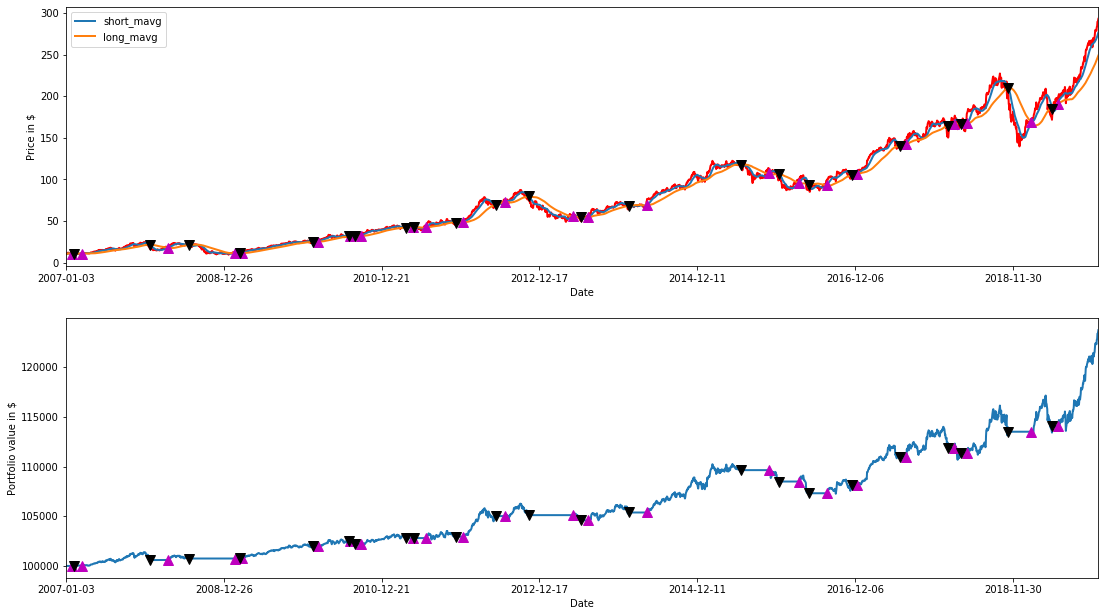

In [41]:


    # Plot two charts to assess trades and equity curve
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    fig.patch.set_facecolor('white')     # Set the outer colour to white
    ax1 = fig.add_subplot(211,  ylabel='Price in $')
    
    # Plot the AAPL closing price overlaid with the moving averages
    main_df2['Price'].plot(ax=ax1, color='r', lw=2.)
    signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

    # Plot the "buy" trades against AAPL
    ax1.plot(signals.index.get_indexer_for(signals[signals.positions == 1.0].index), 
             signals.short_mavg[signals.positions == 1.0],
             '^', markersize=10, color='m')

    # Plot the "sell" trades against AAPL
    ax1.plot(signals.index.get_indexer_for(signals[signals.positions == -1.0].index),
             signals.short_mavg[signals.positions == -1.0],
             'v', markersize=10, color='k')

    # Plot the equity curve in dollars
    ax2 = fig.add_subplot(212, ylabel='Portfolio value in $')
    portfolio['total'].plot(ax=ax2, lw=2.)

    # Plot the "buy" and "sell" trades against the equity curve
    ax2.plot(portfolio.index.get_indexer_for(portfolio[signals.positions == 1.0].index), 
             portfolio.total[signals.positions == 1.0],
             '^', markersize=10, color='m')
    ax2.plot(portfolio.index.get_indexer_for(portfolio[signals.positions == -1.0].index), 
             portfolio.total[signals.positions == -1.0],
             'v', markersize=10, color='k')

    # Plot the figure
    fig.show()

## Method 2: The moving average crossover 

The moving average crossover is when the price of an asset moves from one side of a moving average to the other. This crossover represents a change in momentum and can be used as a point of making the decision to enter or exit the market.

In [42]:
today = dt.date(2008, 1, 1)
simend = dt.date(2019, 12, 31)
tickers = []
transactionid = 0
money = 1000000
portfolio = {}
activelog = []
transactionlog = []

In [43]:
prices=compile_data()
prices.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,55.034485,13.791004,NaN,14.05,27.987869,7.739635,39.919998,19.520000,33.973080,17.299358,...,56.741970,13.940470,37.666531,17.369307,NaN,14.858062,34.880001,71.708916,70.138275,NaN
2007-01-04,54.816502,14.052911,NaN,14.35,28.618711,7.802779,40.820000,19.790001,34.192699,17.307241,...,56.765545,13.952366,37.644257,17.781279,NaN,14.817678,34.680000,73.308632,70.451248,NaN
2007-01-05,54.443768,14.052911,NaN,14.14,28.218664,7.757676,40.619999,19.709999,33.438362,16.810495,...,57.101517,13.672722,37.287640,17.619434,NaN,14.688931,34.330002,73.262131,70.239738,NaN
2007-01-08,54.563339,14.103604,NaN,14.11,28.626410,7.753166,40.450001,19.469999,33.552944,16.573950,...,58.180126,13.672722,37.911713,17.729782,NaN,14.653592,34.400002,72.787804,70.358215,NaN
2007-01-09,54.626602,14.227516,NaN,13.96,28.557161,7.748654,39.630001,19.650000,33.839386,15.895850,...,58.409985,13.666775,37.800270,17.648857,NaN,14.709131,34.340000,72.834297,70.747330,NaN


In [44]:
prices.index = pd.to_datetime(prices.index)

In [45]:
def simulation2() :
    global today, volumechanges, money

    window = 30
    
    start_date_average = today - dt.timedelta(days=window)

    mov_avg  = pd.DataFrame(columns = ['MovingAverage'])
    mov_avg['MovingAverage']=prices.loc[start_date_average:today].mean()
    mov_avg.index.name='ticker'
    
    present=pd.DataFrame(columns = ['PresentValue'])
    present['PresentValue']=prices.loc[today]
    present.index.name='ticker'

    result = pd.merge(mov_avg, present, on='ticker')
    
    interestlst = result[result['PresentValue'] > result['MovingAverage']].index.tolist()
    sell()
    if len(interestlst) > 0 :
        #moneyToAllocate = 500000/len(interestlst)
        moneyToAllocate = money/(2*len(interestlst))
        buy(interestlst, moneyToAllocate)

In [46]:
prices.loc

In [47]:
def main2(tickers):
    global today
    #getindices()
    for ticker in tickers:
        portfolio[ticker] = 0
    while today < simend:
        while not tradingday():
            today += dt.timedelta(days=1)
        simulation2()
        currentpvalue = currentvalue()
        print(currentpvalue, today)
        today += dt.timedelta(days=7)

In [48]:
tickers=prices.columns.to_list()

In [49]:
main2(tickers)

1000000.0 2008-01-02
986119.89 2008-01-09
1000192.13 2008-01-16
960037.88 2008-01-23
975313.7 2008-01-30
959712.66 2008-02-06
950951.87 2008-02-13
998489.95 2008-02-20
997502.16 2008-02-27
985348.19 2008-03-05
959276.72 2008-03-12
955811.91 2008-03-19
975558.68 2008-03-26
988302.59 2008-04-02
1021833.08 2008-04-09
1018825.4 2008-04-16
1015952.15 2008-04-23
1073505.38 2008-04-30
1073241.27 2008-05-07
1089229.64 2008-05-14
1077135.04 2008-05-21
1117063.39 2008-05-28
1109480.68 2008-06-04
1086555.26 2008-06-11
1109326.63 2008-06-18
1038966.09 2008-06-25
1071341.93 2008-07-02
1087148.0 2008-07-09
1084466.51 2008-07-16
1102883.29 2008-07-23
782364.74 2008-07-30
794863.05 2008-08-06
797573.21 2008-08-13
1139413.28 2008-08-20
1138094.16 2008-08-27
1148025.02 2008-09-03
1033740.4 2008-09-10
966017.48 2008-09-17
943053.4 2008-09-24
967078.05 2008-10-01
809743.14 2008-10-08
757188.9 2008-10-15
864756.63 2008-10-22
771069.86 2008-10-29
786216.12 2008-11-05
729639.13 2008-11-12
801630.84 2008-11-1

4338749.35 2015-03-31
4335180.48 2015-04-07
4346346.4 2015-04-14
4345997.73 2015-04-21
4345037.58 2015-04-28
4310305.98 2015-05-05
4324351.63 2015-05-12
4365723.29 2015-05-19
4336074.59 2015-05-26
4346353.46 2015-06-02
4316665.95 2015-06-09
4350290.8 2015-06-16
4392583.37 2015-06-23
4317616.06 2015-06-30
4340625.02 2015-07-07
4382518.25 2015-07-14
4381007.14 2015-07-21
4365407.68 2015-07-28
4403325.77 2015-08-04
4414077.17 2015-08-11
4446846.14 2015-08-18
4137375.36 2015-08-25
4184930.34 2015-09-01
4270136.08 2015-09-08
4271534.14 2015-09-15
4211470.89 2015-09-22
4122568.32 2015-09-29
4220366.78 2015-10-06
4264557.38 2015-10-13
4289056.84 2015-10-20
4305958.23 2015-10-27
4363460.96 2015-11-03
4330819.63 2015-11-10
4290383.17 2015-11-17
4344011.08 2015-11-24
4370392.01 2015-12-01
4302309.74 2015-12-08
4266804.82 2015-12-15
4276087.79 2015-12-22
4323987.4 2015-12-29
4251311.56 2016-01-05
4134964.86 2016-01-12
4087364.31 2016-01-19
4112947.04 2016-01-26
4146885.55 2016-02-02
4069293.53 20

Conclusion : We got 5M USD with a primary investment of 1M USD

## Method 3: Turtle trading

Turtle trading is a popular trend following strategy that was initially taught by Richard Dennis. The basic strategy is to buy futures on a 20-day high and sell on a 20-day low.

In [52]:
prices=compile_data()
prices.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,55.034485,13.791004,NaN,14.05,27.987869,7.739635,39.919998,19.520000,33.973080,17.299358,...,56.741970,13.940470,37.666531,17.369307,NaN,14.858062,34.880001,71.708916,70.138275,NaN
2007-01-04,54.816502,14.052911,NaN,14.35,28.618711,7.802779,40.820000,19.790001,34.192699,17.307241,...,56.765545,13.952366,37.644257,17.781279,NaN,14.817678,34.680000,73.308632,70.451248,NaN
2007-01-05,54.443768,14.052911,NaN,14.14,28.218664,7.757676,40.619999,19.709999,33.438362,16.810495,...,57.101517,13.672722,37.287640,17.619434,NaN,14.688931,34.330002,73.262131,70.239738,NaN
2007-01-08,54.563339,14.103604,NaN,14.11,28.626410,7.753166,40.450001,19.469999,33.552944,16.573950,...,58.180126,13.672722,37.911713,17.729782,NaN,14.653592,34.400002,72.787804,70.358215,NaN
2007-01-09,54.626602,14.227516,NaN,13.96,28.557161,7.748654,39.630001,19.650000,33.839386,15.895850,...,58.409985,13.666775,37.800270,17.648857,NaN,14.709131,34.340000,72.834297,70.747330,NaN


In [53]:
prices.index = pd.to_datetime(prices.index)

In [54]:
today = dt.date(2008, 1, 1)
simend = dt.date(2019, 12, 31)
tickers = []
transactionid = 0
money = 1000000
portfolio = {}
activelog = []
transactionlog = []

In [55]:
tickers=prices.columns.to_list()


In [60]:
def simulation3():
    global today, volumechanges, money
    result = pd.DataFrame()
    
    result['Close']=prices.loc[today]
    result['high']= prices.loc[today].shift(1).rolling(window=20).max()
    result['low']=prices.loc[today].shift(1).rolling(window=20).min()
        
    result.loc[result['high'] < result['Close'], 'Buy'] = 1
    result.loc[result['low'] > result['Close'], 'Sell'] = -1
    

    interestlst = result.loc[result['high']  < result['Close']].index.tolist()
    sellist = result.loc[result['low']  > result['Close']].index.tolist()
    sell2(sellist)
    if len(interestlst) > 0 :
        #moneyToAllocate = 500000/len(interestlst)
        moneyToAllocate = money/(2*len(interestlst))
        buy(interestlst, moneyToAllocate)

In [61]:
def main(tickers):
    global today
    #getindices()
    for ticker in tickers:
        portfolio[ticker] = 0
    while today < simend:
        while not tradingday():
            today += dt.timedelta(days=1)
        simulation3()
        currentpvalue = currentvalue()
      
        print(currentpvalue, today)
        today += dt.timedelta(days=7)

In [62]:
main(tickers)

250095.09 2008-01-16
243358.27 2008-01-23
239248.67 2008-01-30
239911.02 2008-02-06
255099.59 2008-02-13
258023.04 2008-02-20
260248.07 2008-02-27
254347.87 2008-03-05
247353.82 2008-03-12
234597.97 2008-03-19
245892.23 2008-03-26
257264.53 2008-04-02
255304.36 2008-04-09
266328.81 2008-04-16
275767.77 2008-04-23
268164.79 2008-04-30
267876.21 2008-05-07
273545.93 2008-05-14
273704.25 2008-05-21
268542.46 2008-05-28
262759.76 2008-06-04
263761.14 2008-06-11
267930.36 2008-06-18
268949.95 2008-06-25
259646.98 2008-07-02
249469.39 2008-07-09
245792.68 2008-07-16
255226.22 2008-07-23
262113.04 2008-07-30
255344.04 2008-08-06
251292.44 2008-08-13
250262.61 2008-08-20
256189.51 2008-08-27
242623.8 2008-09-03
232414.83 2008-09-10
229041.27 2008-09-17
235836.04 2008-09-24
223172.87 2008-10-01
194435.76 2008-10-08
168092.68 2008-10-15
164794.74 2008-10-22
172307.14 2008-10-29
165869.53 2008-11-05
152215.29 2008-11-12
152559.41 2008-11-19
177089.1 2008-11-26
164854.18 2008-12-03
167672.28 2008-

412380.69 2015-08-04
418948.44 2015-08-11
418272.1 2015-08-18
373998.96 2015-08-25
388448.12 2015-09-01
392976.47 2015-09-08
390759.8 2015-09-15
383003.41 2015-09-22
376111.96 2015-09-29
389414.54 2015-10-06
392281.13 2015-10-13
398655.01 2015-10-20
404015.7 2015-10-27
406183.48 2015-11-03
406260.4 2015-11-10
402787.75 2015-11-17
410854.67 2015-11-24
416510.15 2015-12-01
405417.7 2015-12-08
400748.73 2015-12-15
398119.54 2015-12-22
403871.03 2015-12-29
391675.9 2016-01-05
376313.83 2016-01-12
366339.4 2016-01-19
373370.17 2016-01-26
385038.1 2016-02-02
400014.38 2016-02-09
402991.52 2016-02-16
406299.58 2016-02-23
416331.11 2016-03-01
417926.92 2016-03-08
420034.29 2016-03-15
421214.51 2016-03-22
423566.26 2016-03-29
422818.15 2016-04-05
430832.4 2016-04-12
438412.91 2016-04-19
419452.77 2016-04-26
414302.99 2016-05-03
406898.83 2016-05-10
406314.03 2016-05-17
403768.48 2016-05-24
406835.95 2016-05-31
409304.77 2016-06-07
400614.91 2016-06-14
405038.91 2016-06-21
399678.56 2016-06-28
4

Conclusion : We got 5M USD with a primary investment of 1M USD

## Method 4: The Relative Strength Index (RSI) indicator

The Relative Strength Index (RSI) indicator, as the name suggests, tells us the relative strength of the asset. In other words, the RSI tells us how well the stock is performing (or not) with respect to itself. RSI is counted as a robust technical indicator which can be used to analyse the market and is an important part of the trader’s arsenal as it helps them to make better decisions in timing the market.

In [293]:
prices=compile_data()
prices.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,55.034485,13.791004,NaN,14.05,27.987869,7.739635,39.919998,19.520000,33.973080,17.299358,...,56.741970,13.940470,37.666531,17.369307,NaN,14.858062,34.880001,71.708916,70.138275,NaN
2007-01-04,54.816502,14.052911,NaN,14.35,28.618711,7.802779,40.820000,19.790001,34.192699,17.307241,...,56.765545,13.952366,37.644257,17.781279,NaN,14.817678,34.680000,73.308632,70.451248,NaN
2007-01-05,54.443768,14.052911,NaN,14.14,28.218664,7.757676,40.619999,19.709999,33.438362,16.810495,...,57.101517,13.672722,37.287640,17.619434,NaN,14.688931,34.330002,73.262131,70.239738,NaN
2007-01-08,54.563339,14.103604,NaN,14.11,28.626410,7.753166,40.450001,19.469999,33.552944,16.573950,...,58.180126,13.672722,37.911713,17.729782,NaN,14.653592,34.400002,72.787804,70.358215,NaN
2007-01-09,54.626602,14.227516,NaN,13.96,28.557161,7.748654,39.630001,19.650000,33.839386,15.895850,...,58.409985,13.666775,37.800270,17.648857,NaN,14.709131,34.340000,72.834297,70.747330,NaN


In [294]:
prices.index = pd.to_datetime(prices.index)

In [324]:
today = dt.date(2008, 1, 1)
simend = dt.date(2019, 12, 31)
tickers = []
transactionid = 0
money = 1000000
portfolio = {}
activelog = []
transactionlog = []

In [325]:
tickers=prices.columns.to_list()


Step 1: Closing Price

Step 2: Changes in Closing Price
    
We then compare the closing price of the current day with the previous day’s closing price and note them down.

Step 3: Gain and Loss

We will now create two sections depending on the fact the price increased or decreased, with respect to the previous day’s closing price.
If the price has increased, we note down the difference in the “Gain” column and if it’s a loss, then we note it down in the “Loss” column.

Step 4: Average Gain and Loss
    
In the RSI indicator, to smoothen the price movement, we take an average of the gains (and losses) for a certain period.
For the first 14 periods, it is a simple average of the values.


Step 5: Calculate RS
    
RS = (Avg Gain)/(Avg Loss) 

Step 6: Calculation of RSI
    
RSI = [100 - (100/{1+ RS})]

A trader might buy when the Relative Strength Index is rising and the RSI crosses above the 50 Line. Similarly, a trader might sell when the RSI is falling and the RSI crosses below the 50 Line.


In [326]:
def simulation4():
    global today, volumechanges, money
    
    result = pd.DataFrame()
    result['Close']=prices.loc[today]
    
    result2 = pd.DataFrame()
    result2 = prices.diff() 

    result['chg'] = result2.loc[today]
    
    
    rsi_period = 14 
    #temp=prices.loc[yesterday:today]
    
    result['gain'] = result['chg'].mask(result['chg']<0,0)
    
    result['loss'] = result['chg'].mask(result['chg']>0,0)
   
    result['avg_gain'] = result['gain'].ewm(com = rsi_period - 1, min_periods = rsi_period).mean()
    result['avg_loss'] = result['loss'].ewm(com = rsi_period - 1, min_periods = rsi_period).mean()
  
    result['rs'] = abs(result['avg_gain']/result['avg_loss'])
    result['rsi'] = 100-(100/(1+result['rs']))
    #result.loc[result['rsi'] < result['Close'], 'Buy'] = 1
    #result.loc[result['low'] > result['Close'], 'Sell'] = -1
    

    interestlst = result.loc[result['rsi'] >70].index.tolist()
    sellist = result.loc[result['rsi'] <30].index.tolist()
    sell2(sellist)
    if len(interestlst) > 0 :
        #moneyToAllocate = 500000/len(interestlst)
        moneyToAllocate = money/(2*len(interestlst))
        buy(interestlst, moneyToAllocate)

In [327]:
def main(tickers):
    global today
    #getindices()
    for ticker in tickers:
        portfolio[ticker] = 0
    while today < simend:
        while not tradingday():
            today += dt.timedelta(days=1)
        simulation4()
        currentpvalue = currentvalue()
      
        print(currentpvalue, today)
        today += dt.timedelta(days=7)

In [328]:
main(tickers)

1000000.0 2008-01-02
1000000.0 2008-01-09
1010640.74 2008-01-16
962112.94 2008-01-23
984600.43 2008-01-30
975958.51 2008-02-06
989991.7 2008-02-13
1036309.01 2008-02-20
1027713.88 2008-02-27
1005494.68 2008-03-05
971671.27 2008-03-12
968734.29 2008-03-19
977205.12 2008-03-26
976515.63 2008-04-02
961639.59 2008-04-09
965283.01 2008-04-16
963175.78 2008-04-23
1027639.47 2008-04-30
1021875.6 2008-05-07
1024270.53 2008-05-14
1278000.22 2008-05-21
1048646.22 2008-05-28
1040698.3 2008-06-04
975129.22 2008-06-11
1017579.75 2008-06-18
985165.01 2008-06-25
1020107.32 2008-07-02
1039008.21 2008-07-09
1039154.35 2008-07-16
1063732.95 2008-07-23
902536.1 2008-07-30
917076.04 2008-08-06
925871.57 2008-08-13
1100608.63 2008-08-20
1045690.88 2008-08-27
1049299.28 2008-09-03
981400.78 2008-09-10
902046.65 2008-09-17
877364.22 2008-09-24
955395.29 2008-10-01
811648.32 2008-10-08
768784.24 2008-10-15
785759.64 2008-10-22
805338.27 2008-10-29
812474.01 2008-11-05
779173.24 2008-11-12
792619.15 2008-11-19

5031542.16 2015-03-31
5037807.03 2015-04-07
5118153.22 2015-04-14
5160761.0 2015-04-21
4992885.29 2015-04-28
4934061.73 2015-05-05
4936681.25 2015-05-12
4938606.74 2015-05-19
4909587.98 2015-05-26
4906653.64 2015-06-02
4864184.4 2015-06-09
4898915.6 2015-06-16
4956622.26 2015-06-23
4830627.43 2015-06-30
4869550.1 2015-07-07
4927308.02 2015-07-14
4919932.89 2015-07-21
4904664.87 2015-07-28
4922109.77 2015-08-04
4930295.1 2015-08-11
4963853.15 2015-08-18
4583016.9 2015-08-25
4609417.87 2015-09-01
4609417.87 2015-09-08
4617363.55 2015-09-15
4553419.69 2015-09-22
4518738.25 2015-09-29
4647722.77 2015-10-06
4676174.02 2015-10-13
4676710.89 2015-10-20
4674133.89 2015-10-27
4753292.6 2015-11-03
4701967.6 2015-11-10
4673339.8 2015-11-17
4744564.83 2015-11-24
4793005.16 2015-12-01
4674780.35 2015-12-08
4653843.62 2015-12-15
4649651.07 2015-12-22
4716251.42 2015-12-29
4587870.89 2016-01-05
4393531.08 2016-01-12
4252069.08 2016-01-19
4332129.18 2016-01-26
4306921.4 2016-02-02
4296810.39 2016-02-0

Conclusion : We got 7M USD with a primary investment of 1M USD